# **Import Library**

In [1]:
import tensorflow as tf
import os
import random
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import MobileNetV2
from keras.regularizers import l2

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [3]:
data_dir = '/kaggle/input/dataset-capstone-final/Dataset Final'

In [4]:
filepaths=[]
labels=[]
allowed_extensions = ['.png', '.jpeg', '.jpg'] 
classlist=os.listdir(data_dir)
for img_class in classlist:
    classpath=os.path.join(data_dir,img_class)
    if os.path.isdir(classpath):
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(img_class)                   
Fseries= pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')    
df=pd.concat([Fseries, Lseries], axis=1)
print (df.head())
print (df['labels'].value_counts())

                                           filepaths    labels
0  /kaggle/input/dataset-capstone-final/Dataset F...  takoyaki
1  /kaggle/input/dataset-capstone-final/Dataset F...  takoyaki
2  /kaggle/input/dataset-capstone-final/Dataset F...  takoyaki
3  /kaggle/input/dataset-capstone-final/Dataset F...  takoyaki
4  /kaggle/input/dataset-capstone-final/Dataset F...  takoyaki
labels
hamburger         1000
french_fries      1000
steak             1000
Nasi Goreng       1000
sashimi           1000
hot_dog           1000
pancakes          1000
sushi             1000
edamame           1000
takoyaki           999
Telur Balado       395
Bubur Ayam         283
Bakso              280
Pempek             247
Lontong Balap      226
Rawon              214
Martabak Telur     193
Name: count, dtype: int64


# **Setting Up Directory** 

In [5]:
train_dir = '/kaggle/working/train'
os.makedirs(train_dir, exist_ok=True)

test_dir = '/kaggle/working/test'
os.makedirs(test_dir, exist_ok=True)

validation_dir = '/kaggle/working/validation'
os.makedirs(validation_dir, exist_ok=True)

In [6]:
train_ratio = .8
test_ratio = .1
validation_ratio = 1 - (train_ratio + test_ratio)

In [7]:
train_data, validation_data = train_test_split(df, test_size=test_ratio, random_state=123)
train_data, test_data = train_test_split(train_data, test_size=validation_ratio, random_state=123)

In [8]:
# Memindahkan file gambar ke direktori yang sesuai


# Memindahkan file gambar ke direktori train
for index, row in train_data.iterrows():
    file_path = row['filepaths']
    label = row['labels']
    destination_dir = os.path.join(train_dir, label)
    os.makedirs(destination_dir, exist_ok=True)
    shutil.copy(file_path, destination_dir)

# Memindahkan file gambar ke direktori test
for index, row in test_data.iterrows():
    file_path = row['filepaths']
    label = row['labels']
    destination_dir = os.path.join(test_dir, label)
    os.makedirs(destination_dir, exist_ok=True)
    shutil.copy(file_path, destination_dir)

# Memindahkan file gambar ke direktori validation
for index, row in validation_data.iterrows():
    file_path = row['filepaths']
    label = row['labels']
    destination_dir = os.path.join(validation_dir, label)
    os.makedirs(destination_dir, exist_ok=True)
    shutil.copy(file_path, destination_dir)

In [9]:
print ('train_df length: ', len(train_data), '  test_df length: ', len(test_data), '  validation_df length: ', len(validation_data))

train_df length:  9587   test_df length:  1066   validation_df length:  1184


# **Data preprocessing & augmentation**

In [10]:
image_size = (224,224)
batch_size = 20

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
)

Found 9583 images belonging to 17 classes.
Found 1066 images belonging to 17 classes.
Found 1184 images belonging to 17 classes.


In [11]:
def show_image_samples(gen):
    classes = train_generator.class_indices
    class_names = list(classes.keys())

    images, labels = next(gen)  # Get a sample batch from the generator
    plt.figure(figsize=(20, 20))
    length = len(labels)
    if length < 25:  # Show a maximum of 25 images
        r = length
    else:
        r = 25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image = images[i]
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = class_names[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

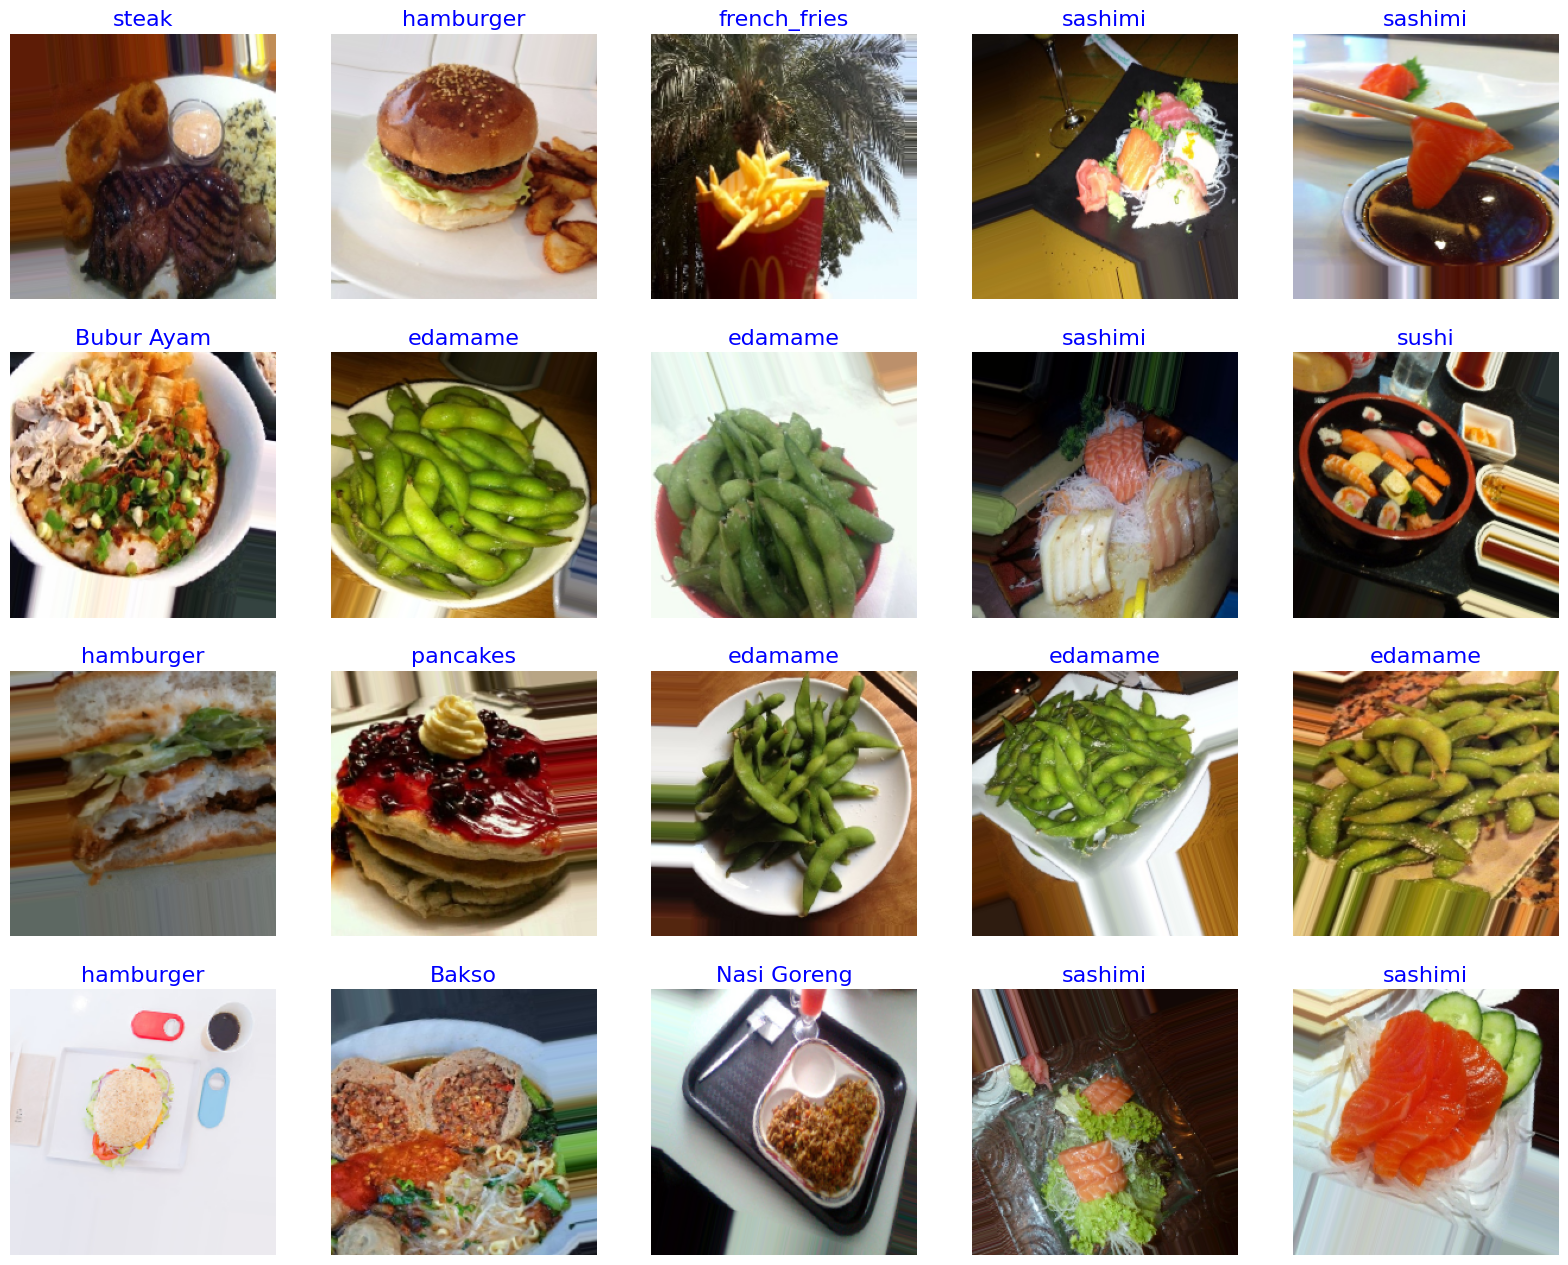

In [12]:
show_image_samples(train_generator)

# **Model Training**
with **Transfer Learning**

In [13]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [14]:
x = base_model.output
x = GlobalAveragePooling2D()(x)  
#x = Dense(256, activation='relu',kernel_regularizer=l2(0.01))(x)  # Tambahkan beberapa layer *dense*
x = Dense(128, activation='relu',kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)  
output_layer = Dense(17, activation='softmax')(x) 

model = Model(inputs=base_model.input, outputs=output_layer)


In [15]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,424,145 (9.25 MB)

 Trainable params: 166,161 (649.07 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [16]:
epochs= 40
verbose = 1


# Callback untuk memberhentikan pelatihan jika val_accuracy tidak meningkat dalam 8 epoch
#early_stopping1 = EarlyStopping(monitor='val_accuracy', patience = 8, mode='max',baseline=0.95,restore_best_weights=True, verbose=1)

# Callback untuk menyimpan model terbaik berdasarkan val_accuracy
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

history = model.fit(
    train_generator,
    epochs=epochs,
    verbose=verbose,
    validation_data=validation_generator,
    callbacks=[checkpoint]
)

Epoch 1/40


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1733743232.168525     119 service.cc:145] XLA service 0x7fd418002dc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733743232.168601     119 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733743232.168607     119 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  1/480 ━━━━━━━━━━━━━━━━━━━━ 1:43:09 13s/step - accuracy: 0.1500 - loss: 4.0741

I0000 00:00:1733743238.688378     119 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


478/480 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.2334 - loss: 2.7664
Epoch 1: val_accuracy improved from -inf to 0.67821, saving model to best_model.keras
480/480 ━━━━━━━━━━━━━━━━━━━━ 135s 255ms/step - accuracy: 0.2342 - loss: 2.7636 - val_accuracy: 0.6782 - val_loss: 1.4575
Epoch 2/40
478/480 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.5669 - loss: 1.6778
Epoch 2: val_accuracy improved from 0.67821 to 0.75929, saving model to best_model.keras
480/480 ━━━━━━━━━━━━━━━━━━━━ 115s 236ms/step - accuracy: 0.5671 - loss: 1.6772 - val_accuracy: 0.7593 - val_loss: 1.1166
Epoch 3/40
479/480 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.6472 - loss: 1.3811
Epoch 3: val_accuracy improved from 0.75929 to 0.78041, saving model to best_model.keras
480/480 ━━━━━━━━━━━━━━━━━━━━ 115s 236ms/step - accuracy: 0.6473 - loss: 1.3809 - val_accuracy: 0.7804 - val_loss: 0.9806
Epoch 4/40
478/480 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.6868 - loss: 1.2347
Epoch 4: val_accuracy improved f

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



478/480 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.8283 - loss: 0.6995
Epoch 28: val_accuracy improved from 0.85811 to 0.87162, saving model to best_model.keras
480/480 ━━━━━━━━━━━━━━━━━━━━ 115s 236ms/step - accuracy: 0.8283 - loss: 0.6995 - val_accuracy: 0.8716 - val_loss: 0.5978
Epoch 29/40
478/480 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.8340 - loss: 0.6712
Epoch 29: val_accuracy did not improve from 0.87162
480/480 ━━━━━━━━━━━━━━━━━━━━ 114s 234ms/step - accuracy: 0.8339 - loss: 0.6713 - val_accuracy: 0.8539 - val_loss: 0.6046
Epoch 30/40
478/480 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.8220 - loss: 0.6917
Epoch 30: val_accuracy did not improve from 0.87162
480/480 ━━━━━━━━━━━━━━━━━━━━ 114s 234ms/step - accuracy: 0.8221 - loss: 0.6916 - val_accuracy: 0.8547 - val_loss: 0.5982
Epoch 31/40
478/480 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.8312 - loss: 0.6661
Epoch 31: val_accuracy did not improve from 0.87162
480/480 ━━━━━━━━━━━━━━━━━━━━ 114s 235ms/step - 

**Further Model Training with Fine-tune**

In [17]:
base_model.trainable = True
for layer in base_model.layers[:-30]:  # Bekukan sebagian besar layer awal
    layer.trainable = False

In [18]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,756,469 (10.52 MB)

 Trainable params: 1,692,561 (6.46 MB)

 Non-trainable params: 731,584 (2.79 MB)

 Optimizer params: 332,324 (1.27 MB)

In [19]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [20]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('best_model_finetuned.keras', monitor='val_accuracy', save_best_only=True, verbose=1)


history_finetune = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,  # Epoch lebih sedikit karena ini fine-tuning
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

Epoch 1/20
407/480 ━━━━━━━━━━━━━━━━━━━━ 17s 242ms/step - accuracy: 0.7144 - loss: 1.0667

I0000 00:00:1733747932.604866     121 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_3', 56 bytes spill stores, 56 bytes spill loads



479/480 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.7172 - loss: 1.0539
Epoch 1: val_accuracy improved from -inf to 0.85304, saving model to best_model_finetuned.keras
480/480 ━━━━━━━━━━━━━━━━━━━━ 137s 253ms/step - accuracy: 0.7172 - loss: 1.0535 - val_accuracy: 0.8530 - val_loss: 0.6124
Epoch 2/20
479/480 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.7785 - loss: 0.8279
Epoch 2: val_accuracy improved from 0.85304 to 0.85980, saving model to best_model_finetuned.keras
480/480 ━━━━━━━━━━━━━━━━━━━━ 115s 235ms/step - accuracy: 0.7785 - loss: 0.8279 - val_accuracy: 0.8598 - val_loss: 0.6003
Epoch 3/20
479/480 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.7961 - loss: 0.7642
Epoch 3: val_accuracy did not improve from 0.85980
480/480 ━━━━━━━━━━━━━━━━━━━━ 115s 236ms/step - accuracy: 0.7962 - loss: 0.7641 - val_accuracy: 0.8573 - val_loss: 0.5919
Epoch 4/20
479/480 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.8137 - loss: 0.7257
Epoch 4: val_accuracy did not improve from 0.85980

# **Evaluate Model**

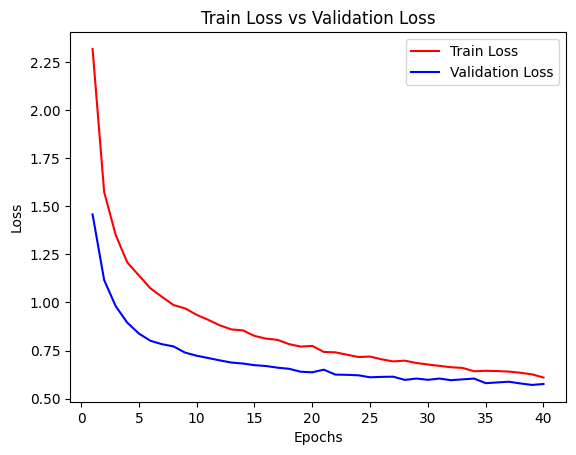

In [21]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Plot train loss dan validation loss
plt.plot(epochs, train_loss, 'r', label='Train Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Train Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

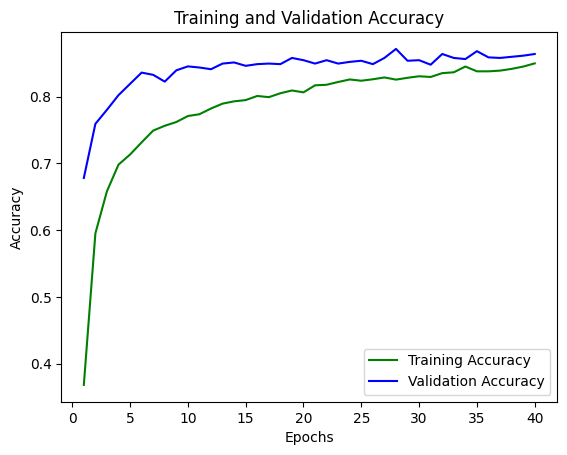

In [22]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(train_accuracy) + 1)

plt.plot(epochs, train_accuracy, 'g', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [35]:
# Evaluasi model (Validasi)
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation Accuracy: {val_accuracy:.2f}")

60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.8789 - loss: 0.5087
Validation Accuracy: 0.89


In [24]:
# Evaluasi model (test)
test_loss, test_acc = model.evaluate(test_generator)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.8611 - loss: 0.5092
Test Loss: 0.49389350414276123
Test Accuracy: 0.8789868950843811


In [27]:
import numpy as np
from sklearn.metrics import classification_report

# Mengumpulkan semua prediksi dan label sebenarnya
y_true = []
y_pred = []

for batch_idx in range(len(validation_generator)):
  # Dapatkan batch data dan label
  images, labels = validation_generator[batch_idx]

  # Prediksi label untuk batch
  predictions = model.predict(images)
  predicted_labels = np.argmax(predictions, axis=1)
  true_labels = np.argmax(labels, axis=1)

  # Tambahkan ke daftar prediksi dan label sebenarnya
  y_true.extend(true_labels)
  y_pred.extend(predicted_labels)

# Menghasilkan classification report
target_names = list(validation_generator.class_indices.keys())  # Nama kelas
report = classification_report(y_true, y_pred, target_names=target_names)

print(report)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━

**Test Using Specialized data set for testing**

In [28]:

def predict_image(img_path):
    # Load image
    img = image.load_img(img_path, target_size=(224, 224))  # Pastikan ukuran gambar sesuai dengan yang diinginkan
    img_array = image.img_to_array(img) / 255.0  # Normalisasi gambar
    img_array = np.expand_dims(img_array, axis=0)  # Menambahkan dimensi batch (None, 224, 224, 3)

    # Prediksi dengan model
    predictions = model.predict(img_array)

    # Mendapatkan label kelas
    class_idx = np.argmax(predictions[0])
    class_label = list(train_generator.class_indices.keys())[class_idx]

    print(f"Predicted Class for {os.path.basename(img_path)}: {class_label}")

def predict_images_in_folder(folder_path):
    # Mengambil semua file gambar dari folder
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        # Memastikan hanya file gambar yang diproses
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            predict_image(img_path)

# Path ke folder yang berisi gambar
test_folder_path = '/kaggle/input/image-test-for-capstone2/image_test'
predict_images_in_folder(test_folder_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Class for rujakcingur.jpg: Bubur Ayam
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted Class for bubu2r.jpg: Bubur Ayam
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted Class for ruajk cingur.jpg: Lontong Balap
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted Class for nasi goreng.jpg: pancakes
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted Class for martabak telur (2).jpg: Martabak Telur
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted Class for 62dbd7ac6e943.jpg: Bubur Ayam
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted Class for bakso (2).jpg: Bakso
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted Class for Lontong balap2.jpg: Lontong Balap
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted Class for rendangs.jpg: Rawon
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted Class for telur balado (2).jpg: Telur Balado
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted Class for testsst.jpg: sushi
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted Class for

# **Label Mapping**
Import to csv

In [29]:
print("Class Indices (Label Mapping):", train_generator.class_indices)

Class Indices (Label Mapping): {'Bakso': 0, 'Bubur Ayam': 1, 'Lontong Balap': 2, 'Martabak Telur': 3, 'Nasi Goreng': 4, 'Pempek': 5, 'Rawon': 6, 'Telur Balado': 7, 'edamame': 8, 'french_fries': 9, 'hamburger': 10, 'hot_dog': 11, 'pancakes': 12, 'sashimi': 13, 'steak': 14, 'sushi': 15, 'takoyaki': 16}


In [30]:
# Dapatkan class indices
class_indices = train_generator.class_indices

# Konversi ke DataFrame
df = pd.DataFrame(list(class_indices.items()), columns=["Class Name", "Label"])

# Simpan ke file CSV
df.to_csv("class_indices.csv", index=False)

print("Class Indices saved to class_indices.csv!")

# Direktori tempat file akan disimpan
directory = "/kaggle/working/my_directory"
filename = "class_indices.csv"
filepath = os.path.join(directory, filename)

# Pastikan direktori ada, jika tidak, buat
os.makedirs(directory, exist_ok=True)

# Dapatkan class indices
class_indices = train_generator.class_indices

# Konversi ke DataFrame
df = pd.DataFrame(list(class_indices.items()), columns=["Class Name", "Label"])

# Simpan ke file CSV di direktori tertentu
df.to_csv(filepath, index=False)

print(f"Class Indices saved to {filepath}!")


Class Indices saved to class_indices.csv!
Class Indices saved to /kaggle/working/my_directory/class_indices.csv!


**Save Model**

In [31]:
model.save('/kaggle/working/Finalm2.h5')